<a href="https://colab.research.google.com/github/lazybuttrying/TensorFlow-Certificate/blob/main/C3/W2/ungraded_labs/C3_W2_Lab_2_sarcasm_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [3]:
# sarcasm.json
!gdown --id 1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v

Downloading...
From: https://drive.google.com/uc?id=1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v
To: /content/sarcasm.json
5.64MB [00:00, 86.5MB/s]


In [4]:
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [5]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [6]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [7]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [9]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [10]:
num_epochs = 30
history = model.fit(training_padded,
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose=2)

Epoch 1/30
625/625 - 6s - loss: 0.6681 - accuracy: 0.5832 - val_loss: 0.5855 - val_accuracy: 0.7424
Epoch 2/30
625/625 - 3s - loss: 0.4348 - accuracy: 0.8257 - val_loss: 0.3874 - val_accuracy: 0.8378
Epoch 3/30
625/625 - 3s - loss: 0.3138 - accuracy: 0.8766 - val_loss: 0.3762 - val_accuracy: 0.8310
Epoch 4/30
625/625 - 3s - loss: 0.2637 - accuracy: 0.8982 - val_loss: 0.3445 - val_accuracy: 0.8577
Epoch 5/30
625/625 - 3s - loss: 0.2288 - accuracy: 0.9101 - val_loss: 0.3494 - val_accuracy: 0.8536
Epoch 6/30
625/625 - 3s - loss: 0.2020 - accuracy: 0.9245 - val_loss: 0.3500 - val_accuracy: 0.8527
Epoch 7/30
625/625 - 3s - loss: 0.1788 - accuracy: 0.9333 - val_loss: 0.3603 - val_accuracy: 0.8535
Epoch 8/30
625/625 - 3s - loss: 0.1610 - accuracy: 0.9403 - val_loss: 0.3716 - val_accuracy: 0.8542
Epoch 9/30
625/625 - 3s - loss: 0.1450 - accuracy: 0.9481 - val_loss: 0.3989 - val_accuracy: 0.8456
Epoch 10/30
625/625 - 2s - loss: 0.1313 - accuracy: 0.9534 - val_loss: 0.4119 - val_accuracy: 0.8483

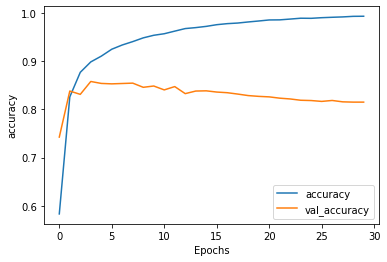

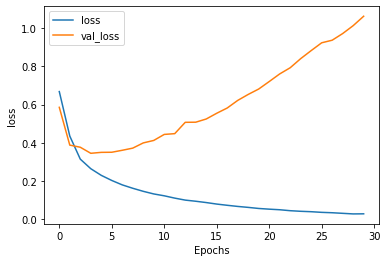

In [11]:
import matplotlib.pyplot as plt

# plot the result

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# validation loss가 이후에 증가하는 안 좋은 모습을 보임

### Let’s talk about the loss function

시간이 지남에 따라 정확한 예측은 증가하지만, 예측 당 신뢰도는 감소함.

이는 계속 주시하며 봐야하며 아래 내용을 그 방법을 소개.

1. 변경 사항에 대해 확인하기
  - vocabulary의 크기, 조금 더 짧은 문장 쓰기, padding을 줄이기 를 한 뒤 다시 실행

Epoch 1/30
625/625 - 3s - loss: 0.5035 - accuracy: 0.7476 - val_loss: 0.4067 - val_accuracy: 0.8126
Epoch 2/30
625/625 - 2s - loss: 0.3765 - accuracy: 0.8253 - val_loss: 0.3978 - val_accuracy: 0.8183
Epoch 3/30
625/625 - 2s - loss: 0.3629 - accuracy: 0.8350 - val_loss: 0.3998 - val_accuracy: 0.8150
Epoch 4/30
625/625 - 2s - loss: 0.3587 - accuracy: 0.8352 - val_loss: 0.4047 - val_accuracy: 0.8147
Epoch 5/30
625/625 - 2s - loss: 0.3558 - accuracy: 0.8378 - val_loss: 0.4024 - val_accuracy: 0.8131
Epoch 6/30
625/625 - 2s - loss: 0.3541 - accuracy: 0.8389 - val_loss: 0.4018 - val_accuracy: 0.8119
Epoch 7/30
625/625 - 2s - loss: 0.3514 - accuracy: 0.8389 - val_loss: 0.4021 - val_accuracy: 0.8146
Epoch 8/30
625/625 - 2s - loss: 0.3504 - accuracy: 0.8409 - val_loss: 0.4019 - val_accuracy: 0.8156
Epoch 9/30
625/625 - 2s - loss: 0.3454 - accuracy: 0.8431 - val_loss: 0.3988 - val_accuracy: 0.8123
Epoch 10/30
625/625 - 2s - loss: 0.3410 - accuracy: 0.8444 - val_loss: 0.4028 - val_accuracy: 0.8125

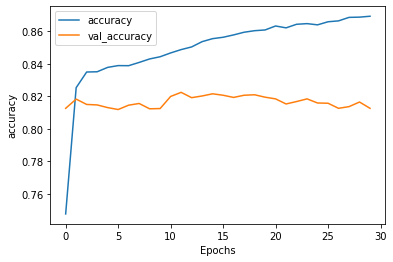

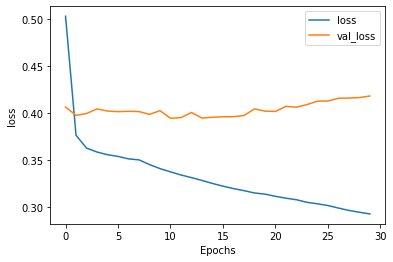

In [18]:
vocab_size = 1000  # 10000->1000
embedding_dim = 32 # 16->32
max_length = 16   # 32->16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

num_epochs = 30
history = model.fit(training_padded,
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    verbose=2)

import matplotlib.pyplot as plt

# plot the result

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# validation loss가 증가하진 않게 됨

In [12]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [13]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [14]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [15]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[9.035625e-01]
 [2.897345e-06]]
